# Trading strategy evaluation 

I, along with 99.99% of the population, want to be rich. What should I do about it? Obviously, Google "how to become rich," and inevitably end up reading about FOREX trading. And let me tell you, there is no shortage of advisors in this area. Every corner of the internet has someone ready to tell you they’ve cracked the market: open an account, slap on a few indicators, follow their tips for just $9.99, and boom, you’re rolling in cash!

So, I dived in. But unfortunately, I’m a very boring person, so I bought a book instead. No, I’m not giving you the title, but the main idea was that the right combination of three indicators would do the trick.

Since I’m not only boring but also poor, I’m not exactly eager to part with the little fortune I have. So, let me try something different—let me try to predict the wealth I could expect with just a dash of statistics.

Here’s the plan:

- Get data from an actual trading source — OANDA, for instance.
- Write a script to simulate trading with indicators, strategy returns, and, of course, account for the ever-so-fun trading commission.
- Strategies. Are we stopping with just the strategies from the book? Let’s expand the three-indicator rule from the book and create a bunch of trading strategies using different combinations of buy/sell signals. I managed to generate 2,500 combinations, but honestly, the only limit is your imagination (and probably your CPU’s patience).
- Backtest them all on the same pair and period. No favoritism here.
- Find the top performer—who's going to take the cake?
- Decide whether it’s actually a cake or just a breadcrumb that fell off the pile.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas_ta as ta
import trade
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

# Set global style parameters using rcParams
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False, 
    'axes.labelcolor': '#565656',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.titlesize': 16,
    'axes.titlepad': 20,
    'axes.titlecolor': '#343aeb',
    'xtick.color': '#565656',
    'xtick.labelsize': 10,
    'ytick.color': '#565656',
    'ytick.labelsize': 10,
    'patch.edgecolor': 'black',
    'patch.force_edgecolor': True,
    'patch.facecolor': 'white',
    'patch.linewidth': 0.5
})

## Testing the water: Book Strategies

### BOOK STRATEGY 1: Two SMMA + Bollinger Band

**For Buy/Long Entry:**

- Enter a long trade when a candle closes above the upper Bollinger Band.
- The 3-period SMMA crosses above the 5-period SMMA.
- The candle’s closing price is above the day’s opening price.
- Set a stop loss and take profit at 20 pips.

**For Sell/Short Entry:**

- Enter a short trade when a candle closes below the lower Bollinger Band.
- The 3-period SMMA crosses below the 5-period SMMA.
- The candle’s closing price is below the day’s opening price.
- Set a stop loss and take profit at 20 pips.

Theoretically suitable for timeframes from 1 minute to 1 hour.

**Only enter if the day trend is up. Only enter if the day trend is down.**

Clear enough! Let's go

## Data loading and preprocessing

In [2]:
# set a pair and time period 
pair = 'EUR_USD'
granularity = 'H1'  #granularity in OANDA format
pip = 0.0001        # set pip value of the pair
year = 2021     # select only year of interest

# import data as datafreme
df = pd.read_pickle( f"hist_data/{pair}_{granularity}.pkl" )

# keeping numeric format of prices 
not_num_cols = ['volume','time']
num_col = [x for x in df.columns if x not in not_num_cols ]
df[num_col] = df[num_col].apply(pd.to_numeric)

# set time of the candle as index and keep only year of interest
df.index = pd.to_datetime(df.time)
df = df[df.index.year == year]

# spread
df['Spr'] = (df.ask_c - df.bid_c)

# keep only midle prices, renaming columns and dropiing unused
df.rename(columns = {'volume':'Volume','mid_o':'Open','mid_c':'Close','mid_l':'Low','mid_h':'High','time':'Date'}, inplace=True)
df = df.drop(['bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c'],axis=1)

print('Number of candles', len(df))
print('Columns: \n', df.columns)


Number of candles 6238
Columns: 
 Index(['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Spr'], dtype='object')


## Short day trend: whether current price is above or below day opening price

In [3]:
# create dataframe with dates only 
df['Dates'] = df.index.date
index_list =sorted(set(df['Dates']))
df_1D = pd.DataFrame( index = index_list, columns = [ 'Open' ]  )
df_1D.Open = [ df['Open'][ df.Dates == idx ][0] for idx in index_list ]

# create a columne with an opening price of the date
df['Date_start'] = np.nan 
for date in df_1D.index:
    df.Date_start[(date.year == df.index.year) & (date.month == df.index.month) \
                   & (date.day == df.index.day)] = df_1D.Open[ df_1D.index == date ][0]
df['Date_start'].ffill( inplace = True)

# create short trend of the day: 1 - if current price above day open, -1 - if current price below day open
df['Short_trend'] = np.where( df.Date_start < df.Close, 1, 0 )
df['Short_trend'] = np.where( df.Date_start > df.Close, -1, df.Short_trend )

In [4]:
df.head()

,Date,Volume,Open,High,Low,Close,Spr,Dates,Date_start,Short_trend
time,,,,,,,,,,
2021-01-03 22:00:00+00:00,2021-01-03T22:00:00.000000000Z,184,1.22400,1.22427,1.22324,1.22342,0.00063,2021-01-03,1.22400,-1
2021-01-03 23:00:00+00:00,2021-01-03T23:00:00.000000000Z,1623,1.22339,1.22528,1.22310,1.22500,0.00017,2021-01-03,1.22400,1
2021-01-04 00:00:00+00:00,2021-01-04T00:00:00.000000000Z,2930,1.22498,1.22498,1.22388,1.22409,0.00016,2021-01-04,1.22498,-1
2021-01-04 01:00:00+00:00,2021-01-04T01:00:00.000000000Z,3149,1.22410,1.22558,1.22400,1.22527,0.00014,2021-01-04,1.22498,1
2021-01-04 02:00:00+00:00,2021-01-04T02:00:00.000000000Z,2640,1.22526,1.22586,1.22496,1.22542,0.00015,2021-01-04,1.22498,1


FINAL RETURN :  95.81 
MAX RETURN:  100.97 
MIN RETURN:  94.93 


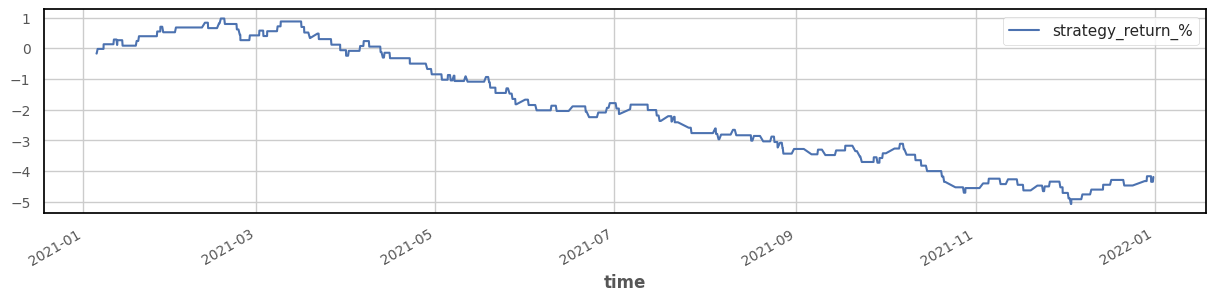

In [5]:
# set indicators values:
# two SMMA
df['SMMA_3'] = ta.sma(df.Close,3)
df['SMMA_5'] = ta.sma(df.Close,5)
# Bol. band
df['BB'] = ta.ema(df.Close,20)
df['BB_up'] = df.BB + 0.8*df.Close.rolling(20).std() 
df['BB_down'] = df.BB - 0.8*df.Close.rolling(20).std() 

# booline arrays whether the entring conditions satisfied - 1, or not 0  
enter_long_1 =  np.where( ( df.BB_up.shift() > df.Close.shift() ) & ( df.BB_up < df.Close ) \
                        & ( df.SMMA_3 > df.SMMA_5 ) & ( df.SMMA_3.shift() < df.SMMA_5.shift() ) \
                        & ( df.Short_trend == 1) 
                          , 1,  0)
                
enter_short_1 = np.where( ( df.BB_down.shift() < df.Close.shift() ) & ( df.BB_down > df.Close ) \
                        & ( df.SMMA_3 < df.SMMA_5 ) & ( df.SMMA_3.shift() > df.SMMA_5.shift() ) \
                        & ( df.Short_trend == -1)
                         , 1,  0)

# set a stop price and take profit price (array)
stop_price = df.Close*0 + 20*pip
exit_price = df.Close*0 + 20*pip

# trading simulator enters long/short position if condition is satisfied and exit when stop prise/exit price is reached
Strategy_1 = trade.trade_simulator(df.Close, df.High, df.Low, df.Spr, 
                                        enter_long_1, 
                                        enter_short_1,  
                                        take_profit = exit_price, 
                                        stop_loss = stop_price, 
                                      )
df['Position'] = Strategy_1[1]
df['Win_loss'] = Strategy_1[0]

Strategy_return_1 = trade.strategy_return(df, 'Win_loss', 'Position')


-5% return over a year won't make me rich. 

Let's try again.

### BOOK STRATEGY 2: Stochasticcs + SMA + RSI

**For Buy/Long Entry:**

- Entry long trade when price crosses above the moving average
- The Stochasticcs are above 50 and cross below
- RSI crosses above level 70
- Candle close price is above day open price
- Stop loss and Take profit = 20 pips

**For Sold/Short Entry:**

- Entry long trade when price crosses above the moving average
- The Stochasticcs are below 50 and cross up
- RSI crosses below level 30
- Candle close price is below day open price
- Stop loss and Take profit = 20 pips

Same conditions: suitable for timeframes from 1 minute to 1 hour.
**Only enter if the day trend is up. Only enter if the day trend is down.**


FINAL RETURN :  95.81 
MAX RETURN:  100.59 
MIN RETURN:  95.53 


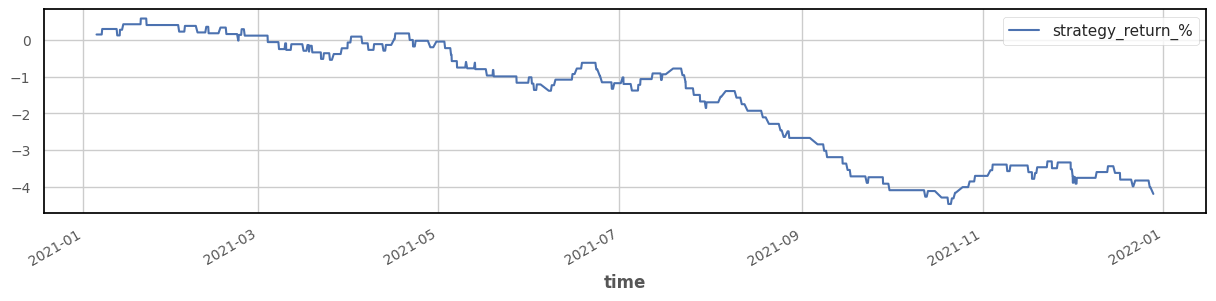

In [6]:
df['RSI_3'] = ta.rsi(df.Close, 3)
df['SMA'] = ta.sma(df.Close, 12)

Stochstics = ta.stoch(close = df.Close, high=df.High,low=df.Low, k=12, d = 3, smooth = 4)
df['STOCHk'] = Stochstics.iloc[:,0]
df['STOCHd'] = Stochstics.iloc[:,1]

enter_long_2 = (df.SMA < df.Close) & (df.SMA.shift() > df.Close.shift()) \
                & (df.RSI_3 > 70) & (df.RSI_3.shift() < df.RSI_3) \
                & (df.STOCHk < 50) & (df.STOCHk-df.STOCHd > 0) & ( df.Short_trend == 1)

enter_short_2 = (df.SMA > df.Close) & (df.SMA.shift() < df.Close.shift()) \
                & (df.RSI_3 < 30) & (df.RSI_3.shift() > df.RSI_3) \
                & (df.STOCHk > 50) & (df.STOCHk-df.STOCHd < 0) & ( df.Short_trend == -1)

Strategy_2 = trade.trade_simulator(df.Close, df.High, df.Low, df.Spr, 
                                        enter_long_2, 
                                        enter_short_2,  
                                        take_profit = exit_price, 
                                        stop_loss=stop_price, 
                                        )

df['Position'] = Strategy_2[1]
df['Win_loss'] = Strategy_2[0]

Strategy_return_2 = trade.strategy_return(df, 'Win_loss', 'Position')


___

## Next Level: 3-indicator Strategy Development

The raw book strategies didn't perform particularly well. So, let's take things to the next level! Instead of relying on a few predefined strategies, we'll develop thousands of strategies and bulk test them to find the best performers.

### Feature Generator:
I wrote Pair_test class for mass strategy testing. It generating features for potential trading opportunities by searching over a selected year and simulating strategy performance. Several key steps:

- Import Data: Load the data for a given pair, time period, and granularity.
- Preprocessing: Clean and prepare the data for analysis.
- Technical Indicators: Apply numerous technical indicators, generating two boolean columns—"enter_long" and "enter_short"—for each indicator. These columns will have the value "True" when the conditions for a long or short position are met, respectively.
- Label Calculation (Labels_2): This step involves creating a binary variable with two classes: 1 and -1. The label is set to 1 if future prices hit the close price + expected profit before close price - expected profit, and set to -1 if the opposite happens.
- Strategy Search: The class systematically searches through all possible strategies, where each strategy is a combination of three indicator entry conditions.

#### Strategy Selection Criteria:

A strategy is retained if:

    (Labels=1 | Strategy=1)/sum(Strategy=1) > threshold rate AND (Labels=-1 | Strategy=-1)/sum(Strategy=-1) > threshold rate.

This ensures that the strategy consistently performs well for both long and short trades, based on the given threshold.

In [7]:
from pair_tester import Pair_tester

pair = 'EUR_USD'
granularity = 'H1'  #granularity in OANDA format
path = 'hist_data/' #path to a data directory

pip = 0.0001

# ATR multiplier and length for expected profit
atr_coef = 2
atr_length = 8

#threshold rate, which strategies to keep, must be <0.5  
threshold = 0.60

In [8]:
start = '2021-01-03 00:00:00+00:00'
end = '2021-12-31 23:00:00+00:00'

test_2021 = Pair_tester(path, pair, granularity, pip, start, end )

test_2021.apply_bunch_of_indicators( )

profit = ta.atr(high=test_2021.df.High, low=test_2021.df.Low, close=test_2021.df.Close, length=atr_length)*atr_coef
test_2021.get_labels(profit)

test_2021.get_best_strategies()

print( "Number of positive (long) and negative (short) upcomming labels:" )
print(test_2021.df.Labels_2.value_counts())

Number of potential strategies:  16
Number of positive (long) and negative (short) upcomming labels:
Labels_2
-1.0    3268
 1.0    2955
Name: count, dtype: int64


In [9]:
test_2021.strategies_df.head()

,Indicator_1,Indicator_2,Indicator_3,short_luck_ratio,long_luck_ratio,short_opps,long_opps
0,SMMA_1_cross,SMA_1_cross,SMA_2_cross,0.453039,0.416413,362,329
1,SMMA_1_cross,SMA_1_cross,SMMA_2_cross,0.500000,0.523810,16,21
2,SMMA_1_cross,SMA_1_cross,BB_1,0.440367,0.450000,109,100
3,SMMA_1_cross,SMA_1_cross,BB_2,0.491803,0.264151,61,53
4,SMMA_1_cross,SMA_1_cross,RSI_14,0.454023,0.419048,348,315


FINAL RETURN :  101.75 
MAX RETURN:  102.09 
MIN RETURN:  99.71 
Wins:  30 ; Losses:  17 ; Win rate:  0.638
Average profit in pips:  21.5 ; Average loss in pips:  25.4


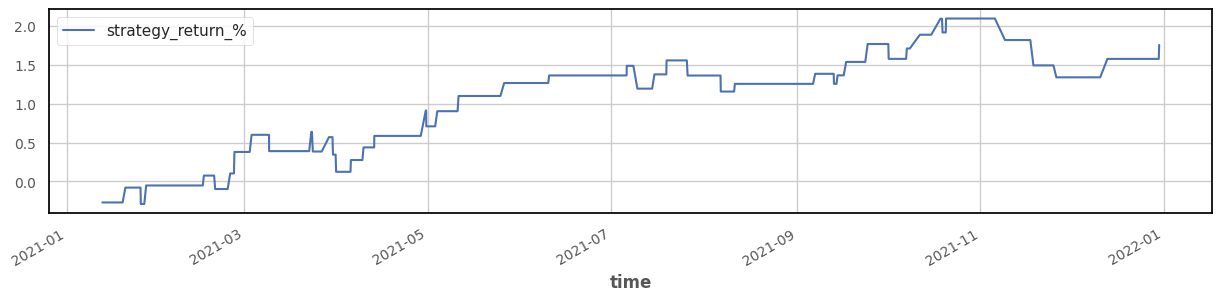

In [10]:
# Checking the first best strategy:
strategy_to_check = 0

Indicator_1 = test_2021.best_strategies.Indicator_1.iloc[strategy_to_check]
Indicator_2 = test_2021.best_strategies.Indicator_2.iloc[strategy_to_check]
Indicator_3 = test_2021.best_strategies.Indicator_3.iloc[strategy_to_check]

enter_condition_long = np.where(  test_2021.df[Indicator_1+'_enter_long'] \
                                & test_2021.df[Indicator_2+'_enter_long'] \
                                & test_2021.df[Indicator_3+'_enter_long']  , 1,  0) 

enter_condition_short = np.where( test_2021.df[Indicator_1+'_enter_short'] \
                                & test_2021.df[Indicator_2+'_enter_short'] \
                                & test_2021.df[Indicator_3+'_enter_short']  , 1,  0)

test_2021.set_enter_condition( enter_condition_long, enter_condition_short )
test_2021.set_stop_loss_vector( profit)
test_2021.set_take_profit_vector(profit)

test_2021.run_simulator()

_, _, _, _, _, _, _ = test_2021.strategy_return(show_plot=True, print_stat=True)


### All top performers trading history: 

In [15]:
def plot_multiple_strategies(data, strategy_range=range(0, 1000)):
    
    plt.figure(figsize=(15, 5))
    
    for strategy_to_check in strategy_range:
        # Extract the indicators for the current strategy
        Indicator_1 = data.best_strategies.Indicator_1.iloc[strategy_to_check]
        Indicator_2 = data.best_strategies.Indicator_2.iloc[strategy_to_check]
        Indicator_3 = data.best_strategies.Indicator_3.iloc[strategy_to_check]
        
        # Define the enter conditions for long and short positions
        enter_condition_long = np.where(data.df[Indicator_1 + '_enter_long'] &
                                        data.df[Indicator_2 + '_enter_long'] &
                                        data.df[Indicator_3 + '_enter_long'], 1, 0)
        
        enter_condition_short = np.where(data.df[Indicator_1 + '_enter_short'] &
                                         data.df[Indicator_2 + '_enter_short'] &
                                         data.df[Indicator_3 + '_enter_short'], 1, 0)
        
        # Set the entry conditions for the strategy
        data.set_enter_condition(enter_condition_long, enter_condition_short)
        
        # Set stop loss and take profit vectors (assuming profit is predefined)
        data.set_stop_loss_vector(profit)
        data.set_take_profit_vector(profit)
        
        # Run the simulator
        data.run_simulator()
        
        # Get strategy outcome and plot it
        data_sl_win_loss = trade.strategy_return(data.df, 'Win_loss', 'Position', print_stat=False, show_plot = False)
        plt.plot(data_sl_win_loss.index, data_sl_win_loss['strategy_return_%'], label=f'Strategy {strategy_to_check}')
    
    # Final plot settings
    plt.title('Strategy Performance Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

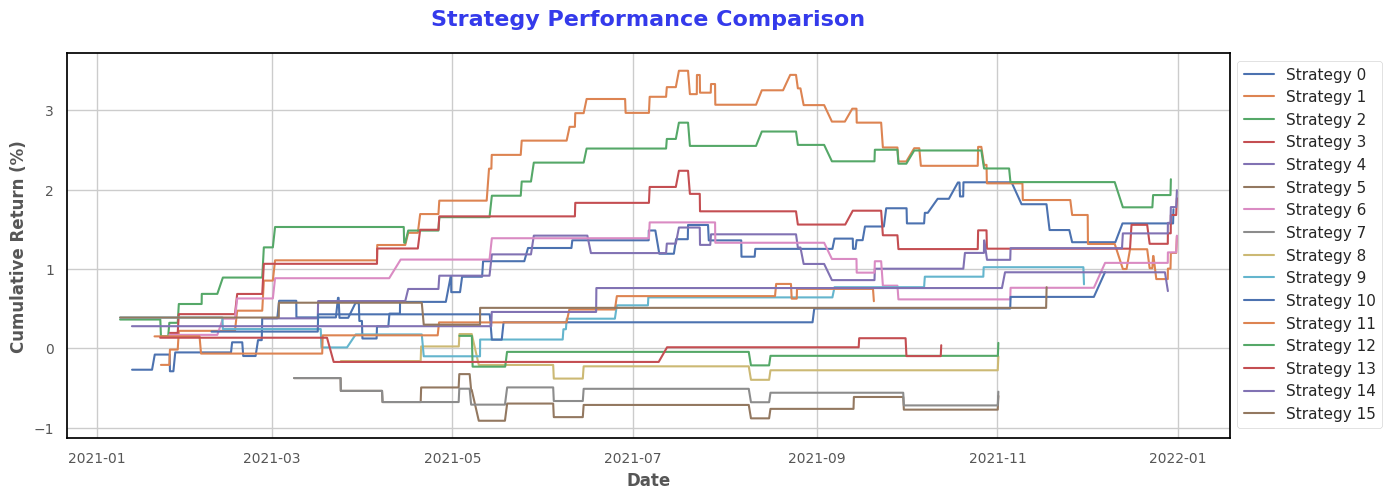

In [16]:
plot_multiple_strategies(test_2021, strategy_range=range(0, 16))

### The top-performing strategies are outstandingly good and consistent... I'm going to be rich!

Nice! But I can't shake off this lingering feeling. Is it actually a unicorn? Maybe I just stumbled upon that one lucky strategy in a valley of crippled horses. Let’s take a deeper look at the distribution of all strategies' final and maximum returns.

*Cue suspense music...*

In [11]:
def process_multiple_strategies(data):
    
    data.run_indicators_search()

    data.strategies_df['wins'] = None
    data.strategies_df['losses'] = None
    data.strategies_df['mean_win'] = None
    data.strategies_df['mean_loss'] = None
    data.strategies_df['returns'] = None
    data.strategies_df['max_return'] = None

    num_strategies = len(data.strategies_df)

    for strategy_to_check in range(0,num_strategies):
        # Extract the indicators for the current strategy
        Indicator_1 = data.strategies_df.Indicator_1.iloc[strategy_to_check]
        Indicator_2 = data.strategies_df.Indicator_2.iloc[strategy_to_check]
        Indicator_3 = data.strategies_df.Indicator_3.iloc[strategy_to_check]
        
        # Define the enter conditions for long and short positions
        enter_condition_long = np.where(data.df[Indicator_1 + '_enter_long'] &
                                        data.df[Indicator_2 + '_enter_long'] &
                                        data.df[Indicator_3 + '_enter_long'], 1, 0)
        
        enter_condition_short = np.where(data.df[Indicator_1 + '_enter_short'] &
                                         data.df[Indicator_2 + '_enter_short'] &
                                         data.df[Indicator_3 + '_enter_short'], 1, 0)
        
        # Set the entry conditions for the strategy
        data.set_enter_condition(enter_condition_long, enter_condition_short)
        
        # Set stop loss and take profit vectors (assuming profit is predefined)
        data.set_stop_loss_vector(profit)
        data.set_take_profit_vector(profit)
        
        # Run the simulator
        data.run_simulator()
        
        # Get strategy outcome and plot it
        wins, losses, mean_win, mean_loss, fin_return, max_return, min_return = data.strategy_return()

        data.strategies_df.at[strategy_to_check, 'wins'] = wins
        data.strategies_df.at[strategy_to_check, 'losses'] = losses
        data.strategies_df.at[strategy_to_check, 'mean_win'] = mean_win
        data.strategies_df.at[strategy_to_check, 'mean_loss'] = mean_loss
        data.strategies_df.at[strategy_to_check, 'returns'] = fin_return
        data.strategies_df.at[strategy_to_check, 'max_return'] = max_return

    return data.strategies_df


In [12]:
big_df = process_multiple_strategies(test_2021)
big_df.head()

,Indicator_1,Indicator_2,Indicator_3,short_luck_ratio,long_luck_ratio,short_opps,long_opps,wins,losses,mean_win,mean_loss,returns,max_return
0,SMMA_1_cross,SMA_1_cross,SMA_2_cross,0.453039,0.416413,362,329,125,152,0.002416,-0.002593,92.308494,103.262354
1,SMMA_1_cross,SMA_1_cross,SMMA_2_cross,0.500000,0.523810,16,21,17,15,0.002037,-0.002252,100.0854,100.64524
2,SMMA_1_cross,SMA_1_cross,BB_1,0.440367,0.450000,109,100,69,81,0.00224,-0.002483,96.024472,100.935872
3,SMMA_1_cross,SMA_1_cross,BB_2,0.491803,0.264151,61,53,34,52,0.002468,-0.002626,95.559695,101.334763
4,SMMA_1_cross,SMA_1_cross,RSI_14,0.454023,0.419048,348,315,125,155,0.002365,-0.002584,91.300635,102.750777


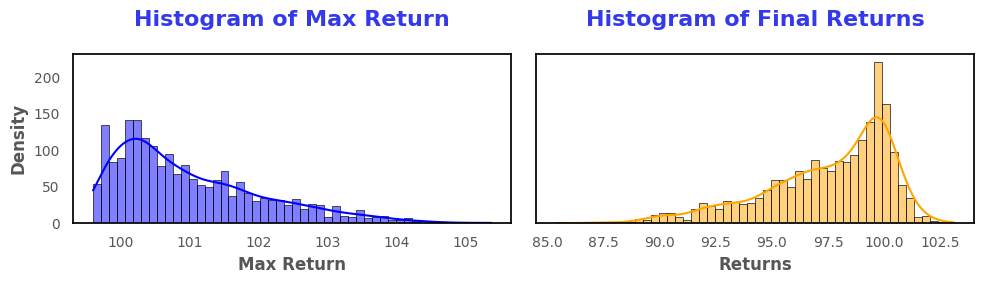

In [13]:
# Creating subplots for side by side histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Plot max_return histogram with density
sns.histplot(big_df['max_return'], bins=50, kde=True, color='blue', ax=axes[0], edgecolor='black')
axes[0].set_title('Histogram of Max Return', fontsize=16, fontweight='bold', color='#343aeb', pad=20)
axes[0].set_xlabel('Max Return', fontsize=12, fontweight='bold', color='#565656')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold', color='#565656')

# Plot returns histogram with density
sns.histplot(big_df['returns'], bins=50, kde=True, color='orange', ax=axes[1], edgecolor='black')
axes[1].set_title('Histogram of Final Returns', fontsize=16, fontweight='bold', color='#343aeb', pad=20)
axes[1].set_xlabel('Returns', fontsize=12, fontweight='bold', color='#565656')

# Customize the layout
plt.tight_layout()
plt.show()

The visualization shows a suspiciously random distribution with a he-a-a-a-a-vy negative tail. And what do we have here? Just a sprinkle of data points barely floating above 0 profitability. Looks like my dream strategy might be more of an outlier than a blueprint for success.

### What about strategies generated around one particular indicator? Let’s take a closer look at the SMMA cross:

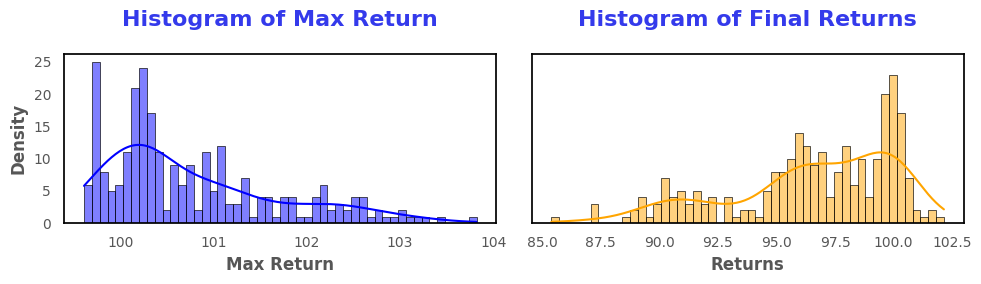

In [14]:
SMMA_1_cross = big_df[ big_df.Indicator_1 == 'SMMA_1_cross']

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Plot max_return histogram with density
sns.histplot(SMMA_1_cross['max_return'], bins=50, kde=True, color='blue', ax=axes[0], edgecolor='black')
axes[0].set_title('Histogram of Max Return', fontsize=16, fontweight='bold', color='#343aeb', pad=20)
axes[0].set_xlabel('Max Return', fontsize=12, fontweight='bold', color='#565656')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold', color='#565656')

# Plot returns histogram with density
sns.histplot(SMMA_1_cross['returns'], bins=50, kde=True, color='orange', ax=axes[1], edgecolor='black')
axes[1].set_title('Histogram of Final Returns', fontsize=16, fontweight='bold', color='#343aeb', pad=20)
axes[1].set_xlabel('Returns', fontsize=12, fontweight='bold', color='#565656')

# Customize the layout
plt.tight_layout()
plt.show()


Sadly, same story. The distribution looks just as random, with the same heavy negative tail. Turns out even focusing on a single indicator like SMMA cross doesn’t save us from the harsh reality of the data.

Now, as a final attempt to determine whether I truly have a shot at making a profit, let’s test one top strategy across multiple time periods for the same pair and granularity.

Does this strategy really hold up, or was it just overfitting to a particular time period during the initial backtest?

*Cue suspense building...*

In [17]:
from datetime import timedelta
import random

def generate_random_start_dates(start_date, end_date, num_dates, period_months):

    start_dates = []
    end_dates = []
    
    # Ensure start_date and end_date are timezone-aware if the data contains timezone-aware datetime
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = pd.to_datetime(end_date, utc=True)
    
    while len(start_dates) < num_dates:
        random_days_offset = random.randint(0, (end_date - start_date).days - period_months * 30)
        random_start = start_date + timedelta(days=random_days_offset)
        random_end = random_start + pd.DateOffset(months=period_months)
        
        if random_end <= end_date:
            start_dates.append(random_start)
            end_dates.append(random_end)
    
    return start_dates, end_dates

def run_strategy_multiple_periods(data, Indicator_1, Indicator_2, Indicator_3, atr_length, atr_coef, num_periods=50, period_months=4):
    # Generate random start and end dates
    start_date = '2009-01-01'
    end_date = '2021-12-31'
    
    # Ensure to pass the period_months argument
    start_dates, end_dates = generate_random_start_dates(start_date, end_date, num_periods, period_months)
    
    # Metrics collection
    metrics = {
        'wins': [],
        'losses': [],
        'mean_win': [],
        'mean_loss': [],
        'fin_return': [],
        'max_return': [],
        'min_return': []
    }
    
    for start, end in zip(start_dates, end_dates):
        # Create a new Pair_tester instance for each random period
        tester = Pair_tester(path, pair, granularity, pip, start, end)
        tester.apply_bunch_of_indicators()
        
        # Calculate the ATR for stop loss/take profit
        profit = ta.atr(high=tester.df.High, low=tester.df.Low, close=tester.df.Close, length=atr_length) * atr_coef
        tester.get_labels(profit)
        
        # Define the enter conditions for long and short positions
        enter_condition_long = np.where(tester.df[Indicator_1 + '_enter_long'] &
                                        tester.df[Indicator_2 + '_enter_long'] &
                                        tester.df[Indicator_3 + '_enter_long'], 1, 0)
        
        enter_condition_short = np.where(tester.df[Indicator_1 + '_enter_short'] &
                                         tester.df[Indicator_2 + '_enter_short'] &
                                         tester.df[Indicator_3 + '_enter_short'], 1, 0)
        
        # Set the entry conditions for the strategy
        tester.set_enter_condition(enter_condition_long, enter_condition_short)
        
        # Set stop loss and take profit vectors
        tester.set_stop_loss_vector(profit)
        tester.set_take_profit_vector(profit)
        
        # Run the simulator
        tester.run_simulator()
        
        # Get strategy outcomes
        strategy_results = tester.strategy_return(show_plot=False, print_stat=False)
        if strategy_results:
            wins, losses, mean_win, mean_loss, fin_return, max_return, min_return = strategy_results
            
            # Store the metrics
            metrics['wins'].append(wins)
            metrics['losses'].append(losses)
            metrics['mean_win'].append(mean_win)
            metrics['mean_loss'].append(mean_loss)
            metrics['fin_return'].append(fin_return)
            metrics['max_return'].append(max_return)
            metrics['min_return'].append(min_return)
    
    # Convert to DataFrame for easier plotting
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

# Function for plotting each metric separately
def plot_metric_histogram(metrics_df, metric_name, title, color, x_min=None, x_max=None):

    # Create the figure with a different size and background color
    plt.figure(figsize=(6, 2))
    
    # Plot the histogram
    sns.histplot(metrics_df[metric_name], bins=40, kde=True, color=color, edgecolor='black', stat="density")
    
    # Set x-axis limits if provided
    if x_min is not None and x_max is not None:
        plt.xlim(x_min, x_max)
    
    # Adding title and labels with a cool style
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel(None)


    # Show plot
    plt.show()

In [18]:
# Example usage
Indicator_1 = test_2021.best_strategies.Indicator_1.iloc[0]
Indicator_2 = test_2021.best_strategies.Indicator_2.iloc[0]
Indicator_3 = test_2021.best_strategies.Indicator_3.iloc[0]
atr_length = 14
atr_coef = 2.0

# Run the strategy across multiple periods
metrics_df = run_strategy_multiple_periods(test_2021, Indicator_1, Indicator_2, Indicator_3, 
                                           atr_length, atr_coef, num_periods=100, period_months=4)

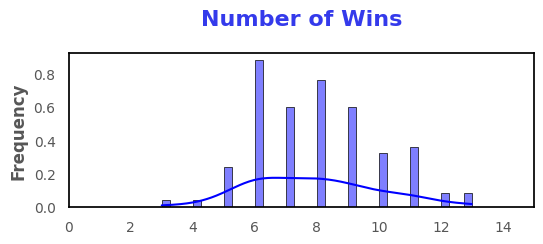

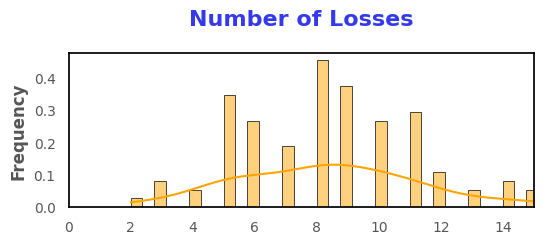

In [28]:
# Plot each metric
plot_metric_histogram(metrics_df, 'wins', 'Number of Wins', 'blue', x_min=0, x_max=15)
plot_metric_histogram(metrics_df, 'losses', 'Number of Losses', 'orange', x_min=0, x_max=15)

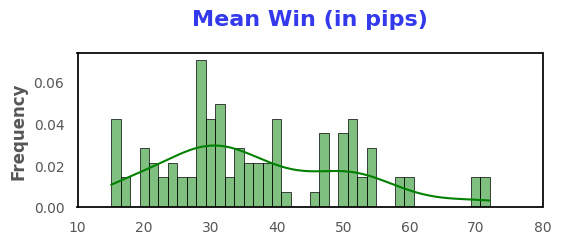

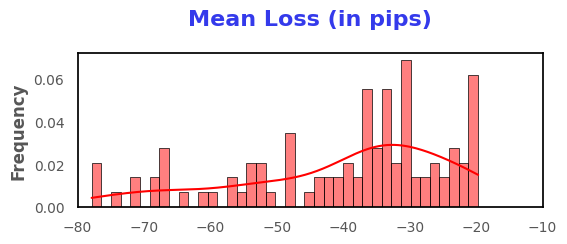

In [29]:
plot_metric_histogram(metrics_df/pip, 'mean_win', 'Mean Win (in pips)', 'green', x_min=0.001/pip, x_max=0.008/pip)
plot_metric_histogram(metrics_df/pip, 'mean_loss', 'Mean Loss (in pips)', 'red', x_min=-0.008/pip, x_max=-0.001/pip)

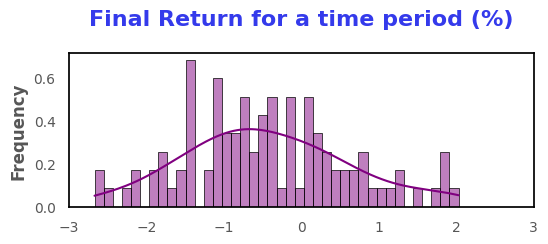

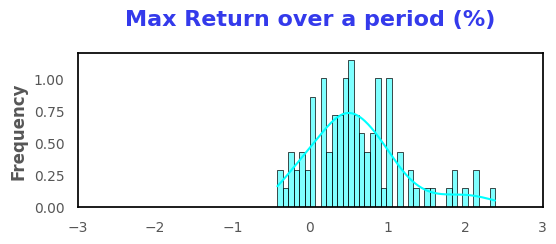

In [30]:
plot_metric_histogram(metrics_df-100, 'fin_return', 'Final Return for a time period (%)', 'purple',x_min=97-100, x_max=103-100)
plot_metric_histogram(metrics_df-100, 'max_return', 'Max Return over a period (%)', 'cyan',x_min=97-100, x_max=103-100)

*Cue sad trombone...*

After 100 trials over 4-month periods with random starting points, the results are, well, disheartening. The mean final returns are  below zero. Sure, the mean max return shows a glimmer of hope in the positive, but does that even matter if the end result is still in the red? The mean number of losses is visibly higher than the number of wins, and to make things worse, the magnitude of losses outweighs the wins.

Looks like the unicorn strategy was more of a gray horse after all.

## What Can We Do to Find Statistically Reliable Strategies?

-----

In [49]:
from skopt import gp_minimize
from skopt.space import Real, Integer
import numpy as np
import pandas as pd

def run_strategy_over_multiple_periods(path, pair, granularity, pip, start_dates, end_dates, params):

    ind_1_1, ind_1_2, ind_1_3 = params[:3]
    ind_2_1, ind_2_2 = params[3:5]
    ind_3_1, ind_3_2, ind_3_3 = params[5:8]
    atr_length = params[8]
    atr_coef = params[9]
    
    returns = []
    n=0
    for start, end in zip(start_dates, end_dates):
        #print(n, 'STARTING NEW PERIOD')
        n+=1
        # Create a new Pair_tester instance for each random period
        data = Pair_tester(path, pair, granularity, pip, start, end)
        
        # Calculate the ATR for stop loss/take profit
        profit = ta.atr(high=data.df.High, low=data.df.Low, close=data.df.Close, length=atr_length) * atr_coef
        data.get_labels(profit)
        
        # Stochastic Oscillator: stoch
        Stochstics = ta.stoch(close=data.df.Close, high=data.df.High, low=data.df.Low, k=ind_1_1, d=ind_1_2, smooth=ind_1_3)
        STOCHk = Stochstics.iloc[:, 0]
        STOCHd = Stochstics.iloc[:, 1]
        enter_long_1 = (STOCHk < 50) & (STOCHk - STOCHd > 0)
        enter_short_1 = (STOCHk > 50) & (STOCHk - STOCHd < 0)

        # Stochastic RSI: stochrsi
        Stochrsi = ta.stochrsi(close=data.df.Close, length=ind_2_1)
        STOCHRSIk = Stochrsi.iloc[:, 0]
        STOCHRSId = Stochrsi.iloc[:, 1]
        enter_long_2 = (STOCHRSIk < 50 - ind_2_2) & (STOCHRSIk > STOCHRSId)
        enter_short_2 = (STOCHRSIk > 50 + ind_2_2) & (STOCHRSIk < STOCHRSId)

        # Quantiles
        EMA = ta.ema(data.df.Close, ind_3_1)
        test_short = data.df.Close - EMA
        test_quant_up = test_short.rolling(ind_3_2).quantile(1 - ind_3_3)
        test_quant_down = test_short.rolling(ind_3_2).quantile(ind_3_3)
        enter_long_3 = (test_short < test_quant_down) & (test_short.shift() > test_quant_down.shift())
        enter_short_3 = (test_short > test_quant_up) & (test_short.shift() < test_quant_up.shift())

        enter_condition_long = np.where(enter_long_1 & enter_long_2 & enter_long_3, 1, 0)
        enter_condition_short = np.where(enter_short_1 & enter_short_2 & enter_short_3, 1, 0)

        # Set the strategy conditions
        data.set_enter_condition(enter_condition_long, enter_condition_short)
        data.set_stop_loss_vector(profit)
        data.set_take_profit_vector(profit)

        # Run the simulator
        data.run_simulator()

        # Collect strategy returns for this period
        strategy_results = data.strategy_return(show_plot=False, print_stat=False)
        
        # Ensure that valid results are returned before adding to returns
        if strategy_results:
            _, _, _, _, fin_return, _, _ = strategy_results
            
            # Add the return only if it is valid (not None)
            if fin_return is not None and not np.isnan(fin_return):
                returns.append(fin_return)
                #print(returns)

            else:
                returns.append(100)
                #print('No trades')

    # Compute the mean return across all sampled periods; handle the case of empty returns
    if returns:
        mean_return = np.mean(returns)
        std_return = np.std(returns)

    else:
        mean_return = -np.inf  # Set a very low return if no valid returns are collected
        std_return = np.inf

    print('Mean Result: ', mean_return, std_return)

    return mean_return, std_return


In [51]:
def objective(params):
    """
    Objective function for optimization. Returns the negative mean return over multiple periods.
    """
    mean_return, std_return = run_strategy_over_multiple_periods(path, pair, granularity, pip, start_dates, end_dates, params)
    return -mean_return 

# Define the search space for the 9 parameters
space = [
    Integer(2, 50),  # ind_1_1
    Integer(2, 20),  # ind_1_2
    Integer(2, 20),  # ind_1_3
    Integer(2, 40),  # ind_2_1
    Integer(0, 45),  # ind_2_2
    Integer(2, 50),  # ind_3_1
    Integer(2, 50),  # ind_3_2
    Real(0.01, 0.1), # ind_3_3
    Integer(5, 50),  # atr_length
    Real(0.5, 3.0)   # atr_coef
]

# Generate random start and end dates
start_date = '2009-01-01'
end_date = '2021-12-31'
num_periods = 20
period_months = 4

start_dates, end_dates = generate_random_start_dates(start_date, end_date, num_periods, period_months)

# Run Bayesian optimization to find the best parameter set
result = gp_minimize(objective, space, n_calls=300, random_state=42)

# Get the best parameters
best_params = result.x
print("Best parameters:", best_params)

# Get the best score (negated mean return, so negate again to get positive mean return)
best_score = -result.fun
print("Best mean return:", best_score)